##  Customer Segmentation Using RFM Analysis

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("Online_Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.tail()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df = df.dropna(subset=["CustomerID","Description"])
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [6]:
df["CustomerID"] = df["CustomerID"].astype("int")
for col in [["InvoiceNo","StockCode","Description","Country"]]:
    df[col] = df[col].astype("category")
df.dtypes

InvoiceNo            category
StockCode            category
Description          category
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country              category
dtype: object

In [7]:
df["Quantity"] = df["Quantity"]>0
df["UnitPrice"] = df["UnitPrice"] >0
df[["Quantity","UnitPrice"]] > 0

,Quantity,UnitPrice
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
541904,True,True
541905,True,True
541906,True,True
541907,True,True


In [8]:
# Adding new column 
df["TotalPrice"] = df['Quantity'] * df["UnitPrice"]


In [9]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"].max()


Timestamp('2011-12-09 12:50:00')

In [10]:
reference_date =df["InvoiceDate"].max() + pd.Timedelta(days=1)
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x : (reference_date - x.max()).days, #Recency: How recently a customer made a purchase
    "InvoiceNo" : lambda y : y.nunique(), #Frequency: How often they made purchases
    "TotalPrice" : "sum"    # Monetary: How much money they spent
}).reset_index()

rfm.rename(columns=({
    "InvoiceDate" :"Recency",
    "InvoiceNo" :  "Frequency",
    "TotalPrice" :"Monetary"
}), inplace=True
)
rfm["Frequency"].sum()


np.int64(22190)

## Scores: 5(Higher), 1(Lower)
- Recent purchase get higher score
- Higher frequency gets higher score
- Higher spending = higher score.

In [11]:
rfm["R_score"] = pd.qcut(rfm["Recency"],5,labels=[5,4,3,2,1]).astype("int") #recent purchase get higher score
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

rfm["RFM_Score"] = rfm["R_score"] + rfm["F_score"] + rfm["M_score"] 
rfm


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,12346,326,2,1,1,2,1,4
1,12347,2,7,182,5,4,5,14
2,12348,75,4,31,2,3,3,8
3,12349,19,1,73,4,1,4,9
4,12350,310,1,17,1,1,2,4
...,...,...,...,...,...,...,...,...
4367,18280,278,1,10,1,2,1,4
4368,18281,181,1,7,1,2,1,4
4369,18282,8,3,12,5,3,1,9
4370,18283,4,16,756,5,5,5,15


### Group similar customers based on their scores

In [12]:
def segment(score):
    if score>=13:
        return "Champions"
    elif score>=10:
        return "Loyal"
    elif score>=7:
        return "Potential loyalist"
    elif score>=4:
        return "New customers"
    else:
        return "Promising"

rfm["Customer_Segment"] = rfm["RFM_Score"].apply(segment)
rfm

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Customer_Segment
0,12346,326,2,1,1,2,1,4,New customers
1,12347,2,7,182,5,4,5,14,Champions
2,12348,75,4,31,2,3,3,8,Potential loyalist
3,12349,19,1,73,4,1,4,9,Potential loyalist
4,12350,310,1,17,1,1,2,4,New customers
...,...,...,...,...,...,...,...,...,...
4367,18280,278,1,10,1,2,1,4,New customers
4368,18281,181,1,7,1,2,1,4,New customers
4369,18282,8,3,12,5,3,1,9,Potential loyalist
4370,18283,4,16,756,5,5,5,15,Champions


### Suggest simple marketing ideas for each group (e.g. discounts for loyal buyers, re-engagement for inactive ones)

In [13]:
marketing_ideas = {
    'Champions': 'Offer exclusive rewards, early access to sales, and VIP treatment.',
    'Loyal': 'Send personalized loyalty offers and discounts to encourage repeat purchases.',
    'Potential loyalist': 'Provide incentives for more frequent purchases (e.g., free shipping, limited-time discounts).',
    'New customers': 'Send welcome offers and introductions to your best products/services.',
    'Promising': 'Retarget with tailored ads or limited-time offers to re-engage them.'
}

# Map the marketing ideas with score
rfm['Marketing_Ideas'] = rfm['Customer_Segment'].map(marketing_ideas)


In [14]:
rfm

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Customer_Segment,Marketing_Ideas
0,12346,326,2,1,1,2,1,4,New customers,Send welcome offers and introductions to your ...
1,12347,2,7,182,5,4,5,14,Champions,"Offer exclusive rewards, early access to sales..."
2,12348,75,4,31,2,3,3,8,Potential loyalist,Provide incentives for more frequent purchases...
3,12349,19,1,73,4,1,4,9,Potential loyalist,Provide incentives for more frequent purchases...
4,12350,310,1,17,1,1,2,4,New customers,Send welcome offers and introductions to your ...
...,...,...,...,...,...,...,...,...,...,...
4367,18280,278,1,10,1,2,1,4,New customers,Send welcome offers and introductions to your ...
4368,18281,181,1,7,1,2,1,4,New customers,Send welcome offers and introductions to your ...
4369,18282,8,3,12,5,3,1,9,Potential loyalist,Provide incentives for more frequent purchases...
4370,18283,4,16,756,5,5,5,15,Champions,"Offer exclusive rewards, early access to sales..."


## Visualize RFM

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


###  Customer Segment Count

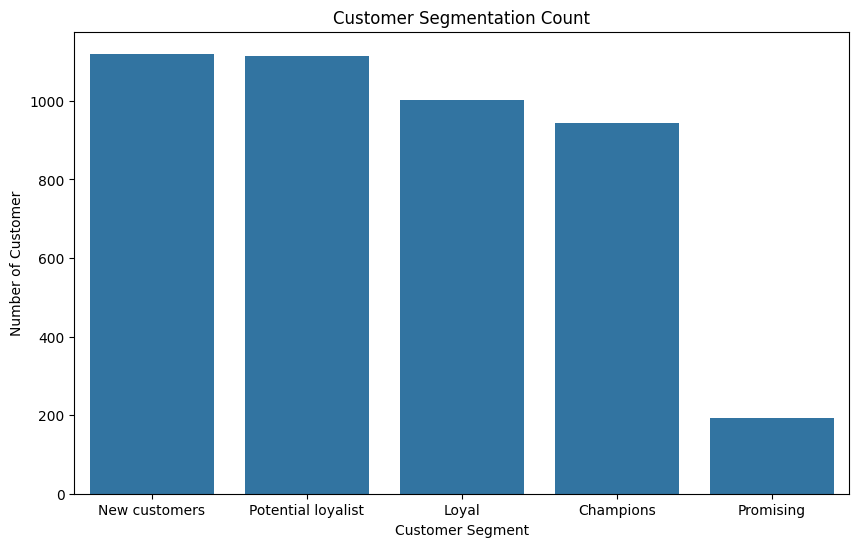

In [20]:
segment_count = rfm["Customer_Segment"].value_counts().reset_index()
segment_count.columns = ["Customer_Segment","Count"]

# bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=segment_count,x="Customer_Segment",y="Count")
plt.title("Customer Segmentation Count")
plt.ylabel("Number of Customer")
plt.xlabel("Customer Segment")
plt.show()

### Average of RFM per Customer Segement

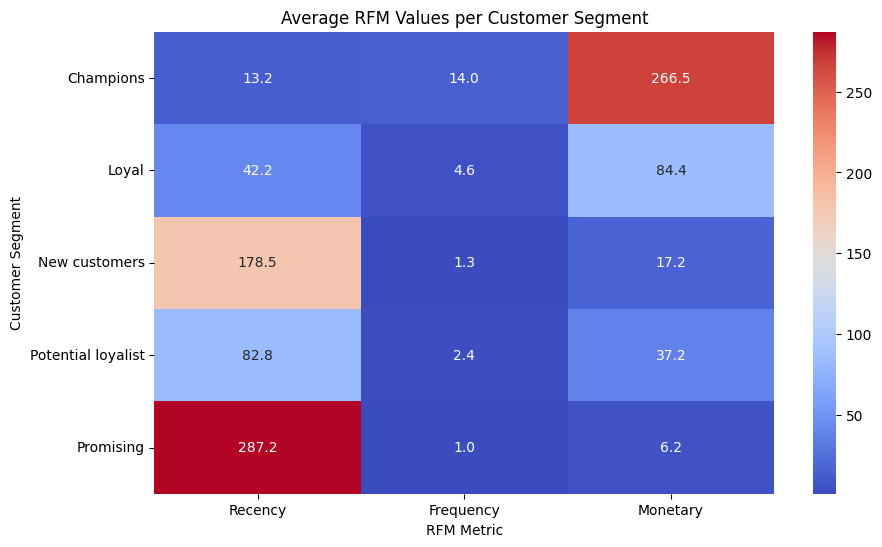

In [21]:
segment_rfm = rfm.groupby('Customer_Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(segment_rfm, annot=True,cmap="coolwarm", fmt=".1f")
plt.title('Average RFM Values per Customer Segment')
plt.ylabel('Customer Segment')
plt.xlabel('RFM Metric')
plt.show()
